In [2]:
#import libraries
# for linear algebra
import numpy as np
# for data processing and file I/O
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# measuring latency
import time

# Encode categorical target variable into numerical labels
from sklearn.preprocessing import LabelEncoder, StandardScaler
# for data preparation
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from sklearn.pipeline import Pipeline

In [3]:
# Load the CIC-IDS2017 data
df_1 = pd.read_parquet("dataset/Benign-Monday-no-metadata.parquet")
df_2 = pd.read_parquet("dataset/Botnet-Friday-no-metadata.parquet")
df_3 = pd.read_parquet("dataset/Bruteforce-Tuesday-no-metadata.parquet")
df_4 = pd.read_parquet("dataset/DDoS-Friday-no-metadata.parquet")
df_5 = pd.read_parquet("dataset/DoS-Wednesday-no-metadata.parquet")
df_6 = pd.read_parquet("dataset/Infiltration-Thursday-no-metadata.parquet")
df_7= pd.read_parquet("dataset/Portscan-Friday-no-metadata.parquet")
df_8 = pd.read_parquet("dataset/WebAttacks-Thursday-no-metadata.parquet")

In [4]:
# Joining the dataframes to a single dataframe
df_data = pd.concat([df_1, df_2, df_3, df_4,  df_5, df_6, df_7, df_8], axis=0, ignore_index=True)
df_data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [4]:
# Data preprocessing
# Display basic information about the dataset
print(df_data.info())

# Check for missing values
print("Missing values per column:")
print(df_data.isnull().sum())

# Check for duplicate rows
duplicates = df_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Display summary statistics
print(df_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313810 entries, 0 to 2313809
Data columns (total 78 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Protocol                  int8   
 1   Flow Duration             int32  
 2   Total Fwd Packets         int32  
 3   Total Backward Packets    int32  
 4   Fwd Packets Length Total  int32  
 5   Bwd Packets Length Total  int32  
 6   Fwd Packet Length Max     int16  
 7   Fwd Packet Length Min     int16  
 8   Fwd Packet Length Mean    float32
 9   Fwd Packet Length Std     float32
 10  Bwd Packet Length Max     int16  
 11  Bwd Packet Length Min     int16  
 12  Bwd Packet Length Mean    float32
 13  Bwd Packet Length Std     float32
 14  Flow Bytes/s              float64
 15  Flow Packets/s            float64
 16  Flow IAT Mean             float32
 17  Flow IAT Std              float32
 18  Flow IAT Max              int32  
 19  Flow IAT Min              int32  
 20  Fwd IAT Total           

In [5]:
# Remove duplicate rows
df_data = df_data.drop_duplicates()

In [6]:
# Identify and display duplicate rows
duplicate_rows = df_data[df_data.duplicated()]
print("Duplicate rows:")

Duplicate rows:


In [7]:
# Display shape of the dataframe
print(f"Dataset shape: {df_data.shape}")

Dataset shape: (2231806, 78)


In [8]:
# Inspect the dataset for categorical columns
print("Categorical column:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

Categorical column: ['Label'] 



In [9]:
# Target feature counts
print(df_data['Label'].value_counts())

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


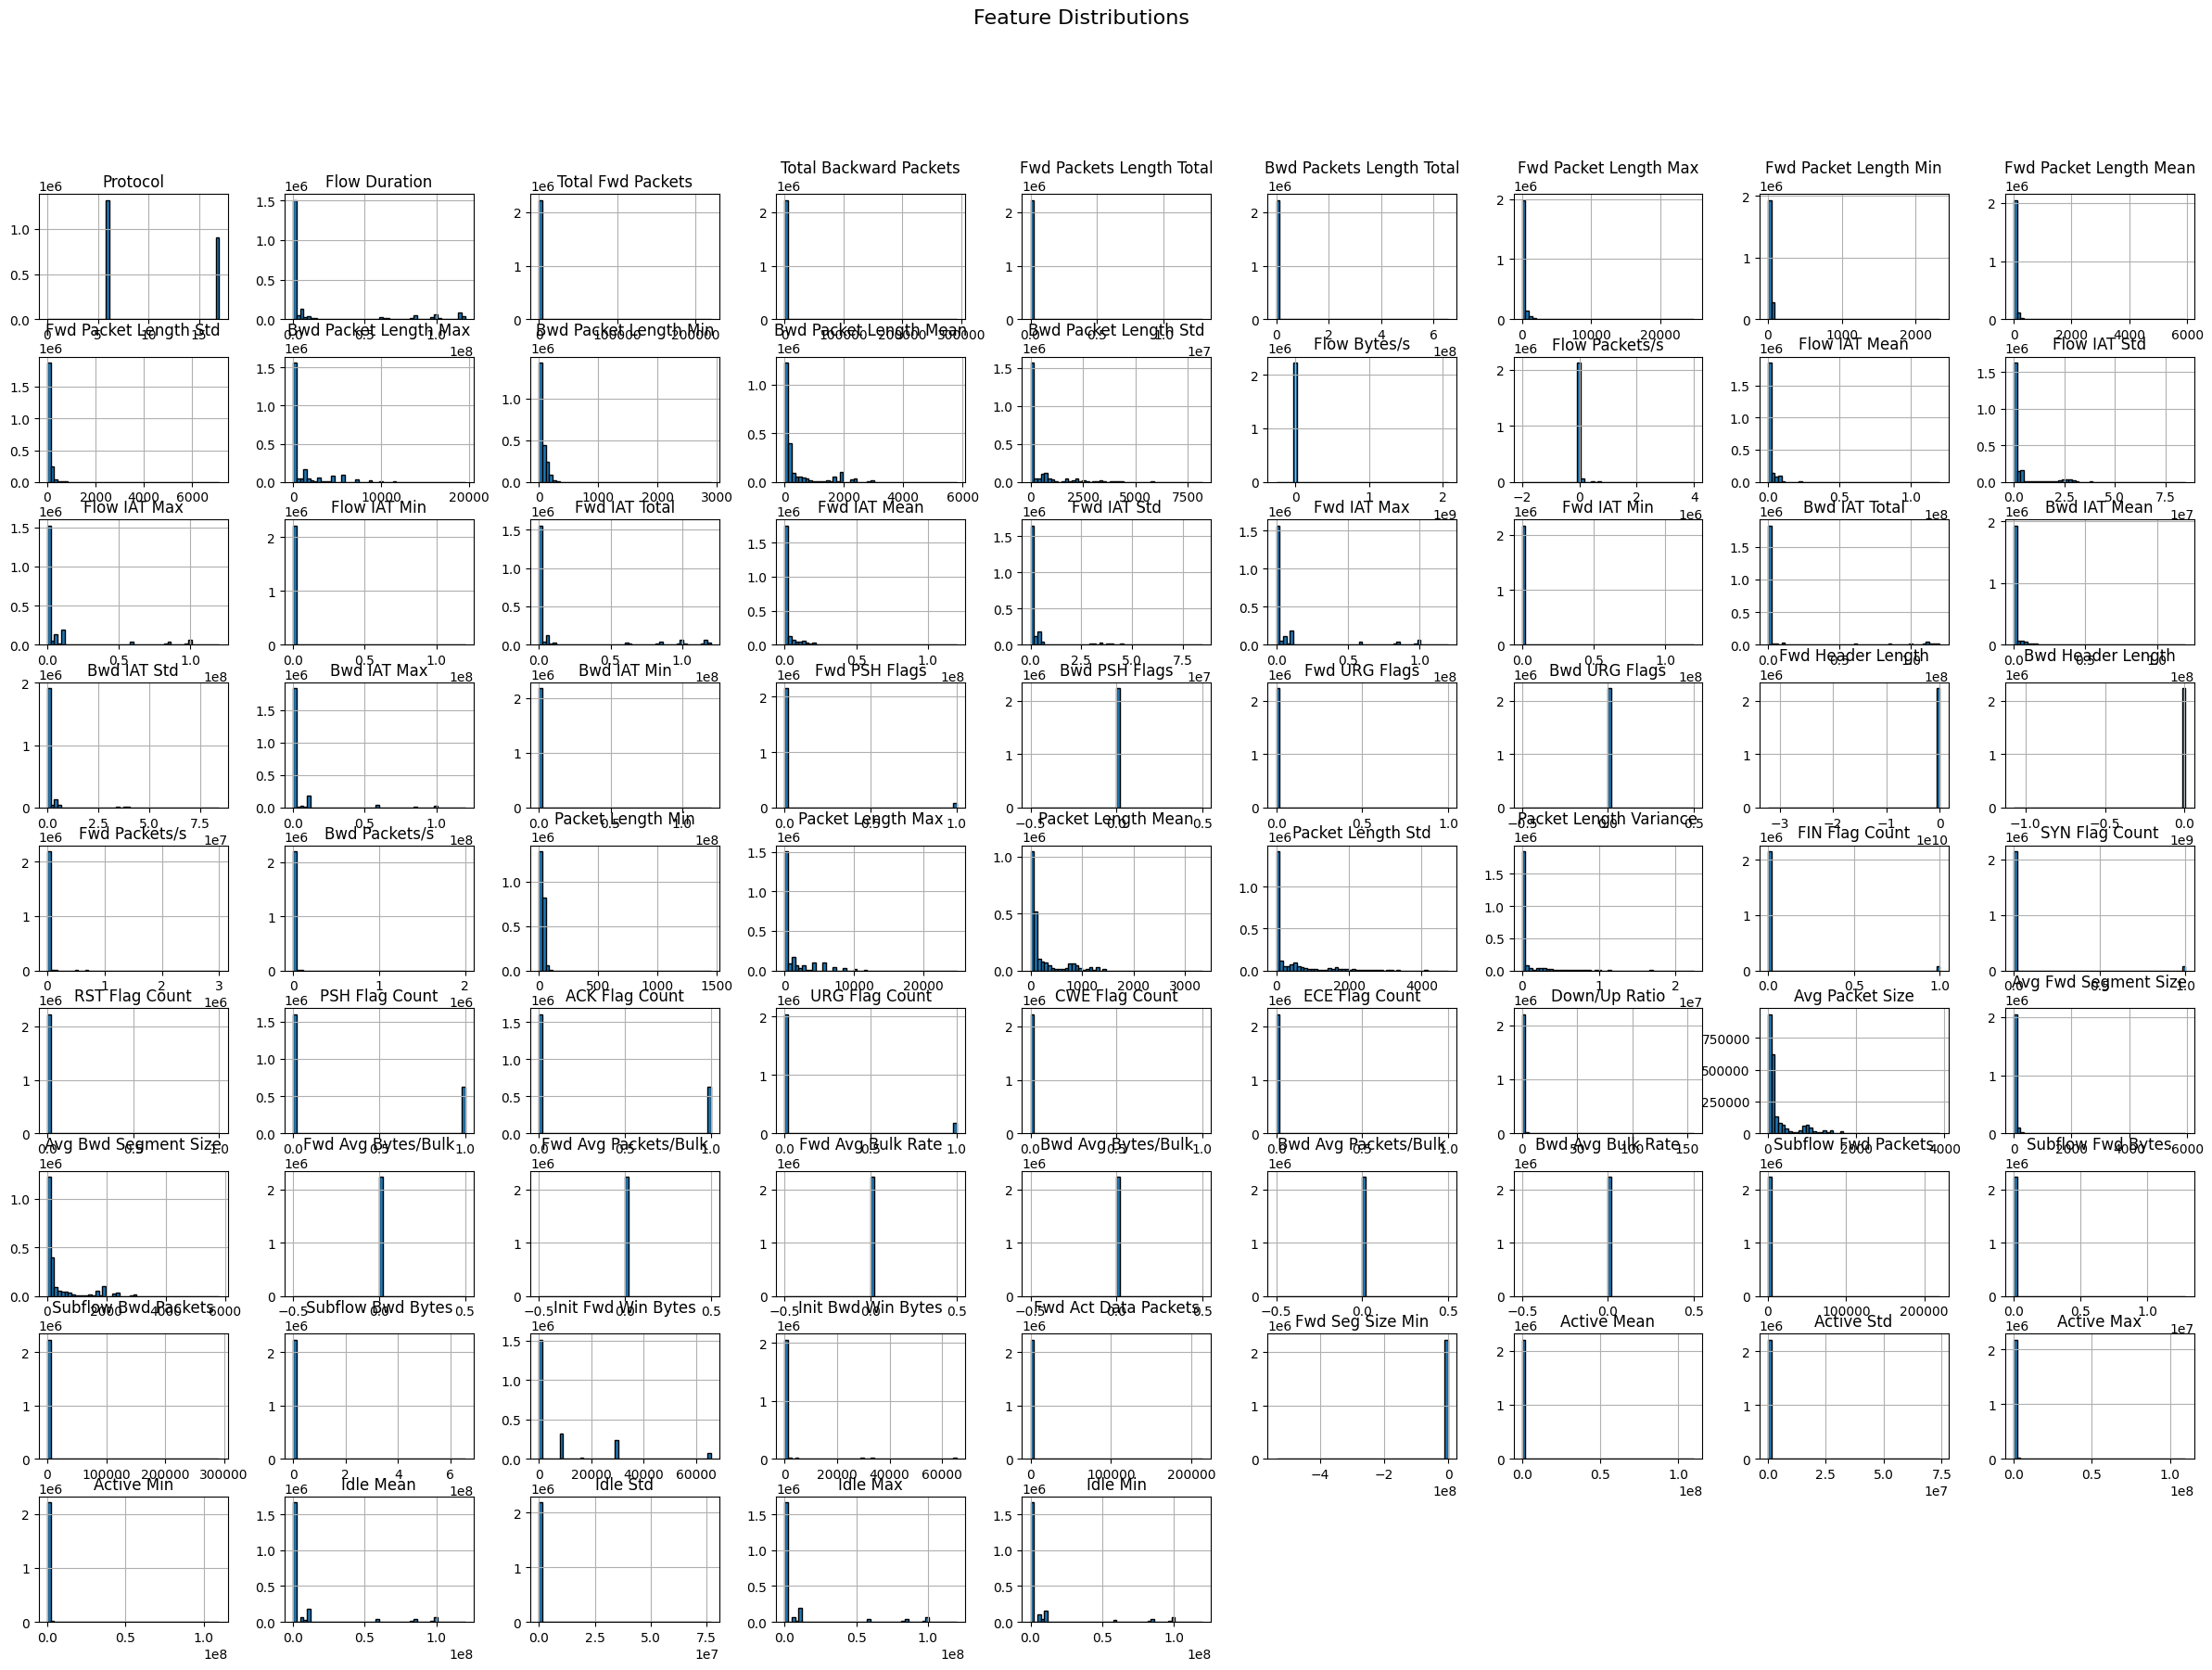

In [10]:
# Plot histograms for each feature to visualize their distribution
df_data.hist(figsize=(30, 20), bins=50, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [11]:
# Extract features as X
X = df_data.copy()
X = X.drop('Label', axis=1)

In [12]:
# Extract target as y
y = df_data['Label'].copy()


In [13]:
# Perform multiclass encoding on the label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [14]:
# Display encoded label values
print("Encoded label values:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Encoded label values:
{'Benign': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


In [15]:
# Splitting the dataset

# Partition the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [16]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Feature Engineering - Adding Interaction Features
X_train_scaled = np.hstack((X_train_scaled, X_train_scaled[:, :5] ** 2))
X_val_scaled = np.hstack((X_val_scaled, X_val_scaled[:, :5] ** 2))
X_test_scaled = np.hstack((X_test_scaled, X_test_scaled[:, :5] ** 2))

In [18]:
## Feature Selection with XGBoost
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, random_state=42)
xgb_clf.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)

# Get feature importances and sort them in descending order
feature_importances = xgb_clf.feature_importances_
important_features = np.argsort(feature_importances)[::-1]
valid_indices = [idx for idx in important_features if idx < X.shape[1]]
X_train_selected = X_train_scaled[:, valid_indices]
X_val_selected = X_val_scaled[:, valid_indices]
X_test_selected = X_test_scaled[:, valid_indices]

In [19]:
# Print important features with importance percentages in descending order
important_feature_names = X.columns[valid_indices]
print("Important Features:")
for feature, importance in zip(important_feature_names, feature_importances[valid_indices]):
    print(f"{feature}: {importance * 100:.2f}%")

Important Features:
Idle Mean: 30.32%
Bwd Packet Length Std: 14.00%
Subflow Bwd Packets: 5.72%
Fwd Act Data Packets: 4.68%
Bwd Packet Length Mean: 4.45%
Fwd IAT Std: 4.41%
Avg Bwd Segment Size: 3.54%
Fwd Packet Length Max: 3.16%
Subflow Bwd Bytes: 2.13%
Fwd Packets Length Total: 1.41%
FIN Flag Count: 1.40%
Total Backward Packets: 1.34%
Fwd IAT Mean: 0.98%
Bwd Packets Length Total: 0.81%
Active Mean: 0.78%
Packet Length Mean: 0.73%
Bwd Packets/s: 0.72%
Flow IAT Std: 0.68%
Packet Length Std: 0.60%
Fwd Packet Length Mean: 0.55%
Avg Packet Size: 0.54%
Total Fwd Packets: 0.51%
Idle Min: 0.47%
Fwd IAT Max: 0.39%
Bwd Packet Length Max: 0.38%
Flow IAT Max: 0.37%
Active Std: 0.37%
Fwd IAT Total: 0.35%
Init Fwd Win Bytes: 0.31%
ACK Flag Count: 0.30%
Active Max: 0.30%
Init Bwd Win Bytes: 0.28%
Flow IAT Mean: 0.28%
Flow Packets/s: 0.27%
Flow IAT Min: 0.27%
Fwd IAT Min: 0.24%
Packet Length Min: 0.23%
Fwd Packet Length Std: 0.23%
Fwd PSH Flags: 0.21%
Fwd Packets/s: 0.19%
SYN Flag Count: 0.19%
Bwd He

In [20]:
# Check the size of the important_features and the DataFrame X
print(len(X.columns))  # Number of columns in X
print(len(important_features))  # Length of important_features


77
82


C:\Users\user\AppData\Local\Temp\ipykernel_21656\285210125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[valid_indices], y=important_feature_names, palette="viridis")


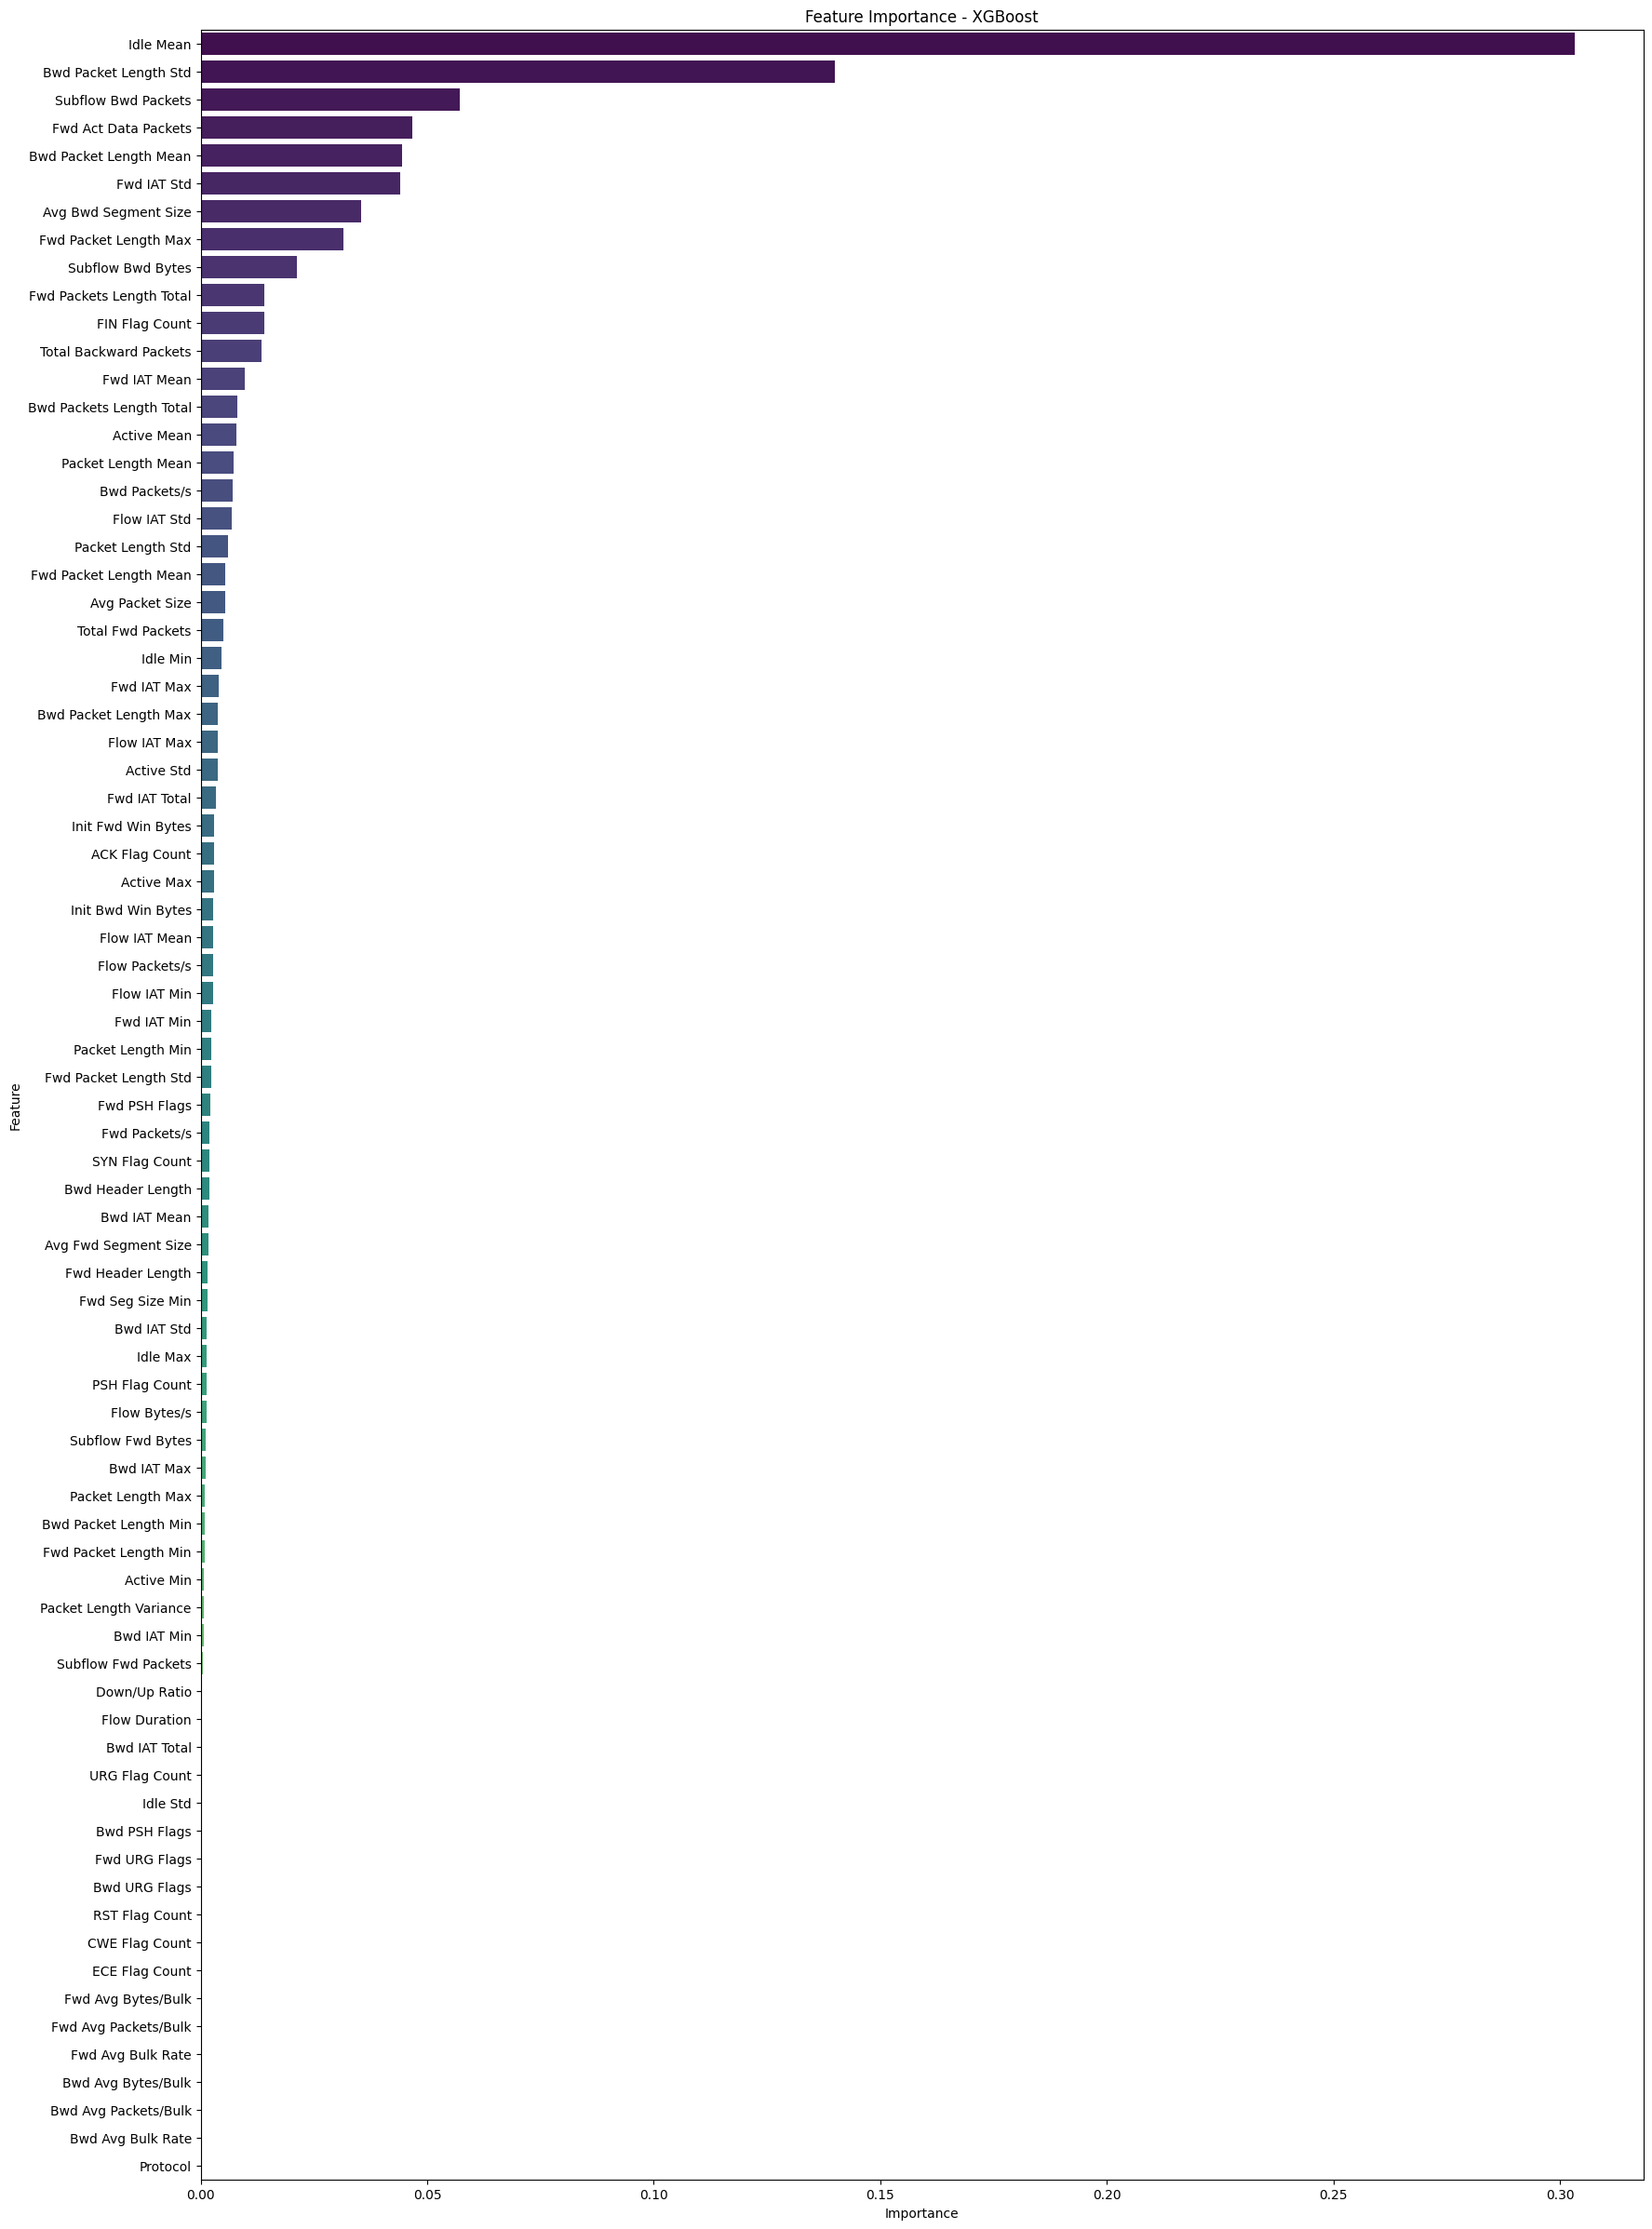

In [25]:
# Plot feature importance
plt.figure(figsize=(20, 30))
sns.barplot(x=feature_importances[valid_indices], y=important_feature_names, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")
plt.show()



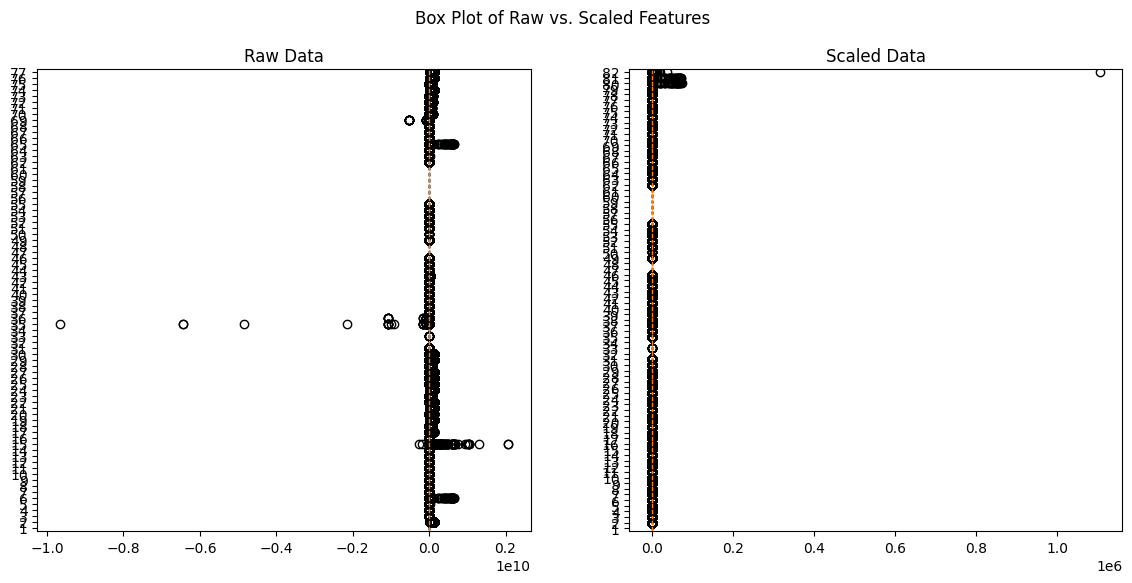

In [26]:
# Box plot for raw vs. scaled data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].boxplot(X_train, vert=False, patch_artist=True)
axes[0].set_title("Raw Data")
axes[1].boxplot(X_train_scaled, vert=False, patch_artist=True)
axes[1].set_title("Scaled Data")
plt.suptitle("Box Plot of Raw vs. Scaled Features")
plt.show()


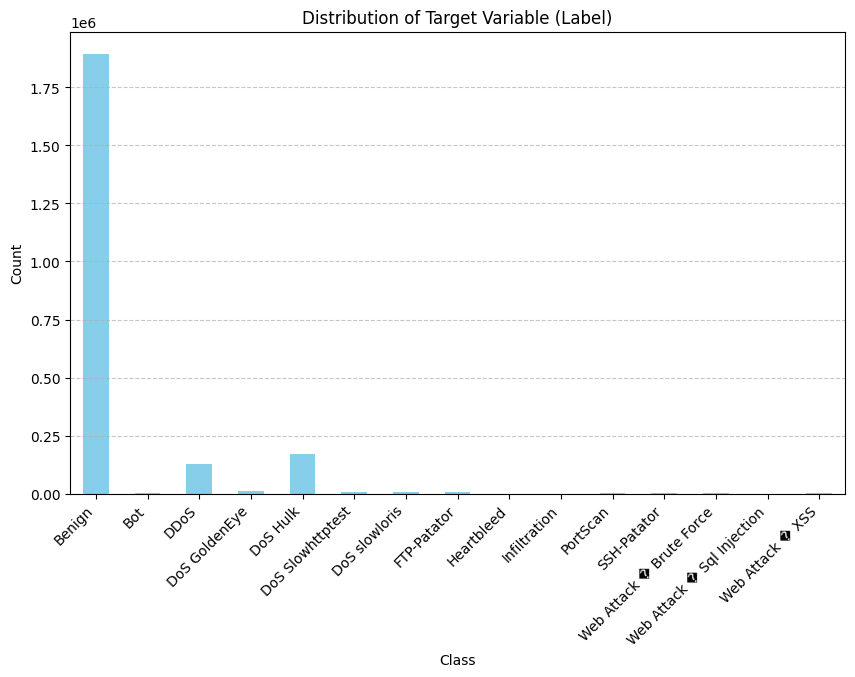

In [27]:
# Check for imbalance and plot the distribution
plt.figure(figsize=(10, 6))
y_series = pd.Series(y)
y_series.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Target Variable (Label)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
# Calculate the count and ratio of each class
# Get the unique values and their counts
class_counts = np.unique(y, return_counts=True)
class_ratios = class_counts[1] / len(y)

# Print the ratio of each class
print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")
print(f"Class 2 ratio: {class_ratios[2]*100:.2f}%")
print(f"Class 3 ratio: {class_ratios[3]*100:.2f}%")
print(f"Class 4 ratio: {class_ratios[4]*100:.2f}%")
print(f"Class 5 ratio: {class_ratios[5]*100:.2f}%")
print(f"Class 6 ratio: {class_ratios[6]*100:.2f}%")
print(f"Class 7 ratio: {class_ratios[7]*100:.2f}%")
print(f"Class 8 ratio: {class_ratios[8]*100:.2f}%")
print(f"Class 9 ratio: {class_ratios[9]*100:.2f}%")
print(f"Class 10 ratio: {class_ratios[10]*100:.2f}%")
print(f"Class 11 ratio: {class_ratios[11]*100:.2f}%")
print(f"Class 12 ratio: {class_ratios[12]*100:.2f}%")
print(f"Class 13 ratio: {class_ratios[13]*100:.2f}%")
print(f"Class 14 ratio: {class_ratios[14]*100:.2f}%")

Class 0 ratio: 84.92%
Class 1 ratio: 0.06%
Class 2 ratio: 5.74%
Class 3 ratio: 0.46%
Class 4 ratio: 7.74%
Class 5 ratio: 0.23%
Class 6 ratio: 0.24%
Class 7 ratio: 0.27%
Class 8 ratio: 0.00%
Class 9 ratio: 0.00%
Class 10 ratio: 0.09%
Class 11 ratio: 0.14%
Class 12 ratio: 0.07%
Class 13 ratio: 0.00%
Class 14 ratio: 0.03%


Understanding the class distribution is critical for evaluating the performance of a machine learning model. Here, the majority class is class 0 while the rest are the minority, therefore, any machine learning model developed for this dataset should aim to outperform this baseline accuracy to demonstrate meaningful predictive power. 

In [30]:
# Train MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=42)
mlp_clf.fit(X_train_selected, y_train)


MLPClassifier(random_state=42)

In [ ]:
# Evaluate MLP Classifier on validation set
y_val_pred = mlp_clf.predict(X_val_selected)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"MLP Classifier Validation Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1:.2%}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLP Classifier Validation Accuracy: 99.49%
Precision: 99.49%
Recall: 99.49%
F1-score: 99.44%


In [31]:
# Evaluate MLP Classifier
y_pred = mlp_clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"MLP Classifier Accuracy: {accuracy:.2%}")


MLP Classifier Accuracy: 99.50%


In [34]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1:.2%}")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 99.46%
Recall: 99.50%
F1-score: 99.46%


In [36]:
# Evaluate MLP Classifier on test set
y_test_pred = mlp_clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"MLP Classifier Test Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1:.2%}")


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MLP Classifier Test Accuracy: 99.50%
Precision: 99.46%
Recall: 99.50%
F1-score: 99.46%


In [39]:
#Save the models

joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(xgb_clf, "xgb_model.pkl")
joblib.dump(mlp_clf, "mlp_model.pkl")


['mlp_model.pkl']

In [43]:
important_features

array([73, 13, 63, 79, 67, 12, 22, 54, 81,  6, 64,  4, 43,  3, 21,  5, 69,
       40, 37, 17, 41,  8, 52,  2, 76, 23, 10, 18, 70, 20, 80, 78, 65, 47,
       71, 66, 16, 15, 19, 24, 38,  9, 30, 36, 44, 35, 26, 53, 34, 68, 27,
       75, 46, 14, 62, 28, 39, 11,  7, 72, 42, 29, 61, 51,  1, 25, 48, 74,
       77, 31, 32, 33, 45, 49, 50, 55, 56, 57, 58, 59, 60,  0],
      dtype=int64)

In [44]:
important_feature_names = X.columns[valid_indices]  # Get selected feature names
print(important_feature_names)


Index(['Idle Mean', 'Bwd Packet Length Std', 'Subflow Bwd Packets',
       'Fwd Act Data Packets', 'Bwd Packet Length Mean', 'Fwd IAT Std',
       'Avg Bwd Segment Size', 'Fwd Packet Length Max', 'Subflow Bwd Bytes',
       'Fwd Packets Length Total', 'FIN Flag Count', 'Total Backward Packets',
       'Fwd IAT Mean', 'Bwd Packets Length Total', 'Active Mean',
       'Packet Length Mean', 'Bwd Packets/s', 'Flow IAT Std',
       'Packet Length Std', 'Fwd Packet Length Mean', 'Avg Packet Size',
       'Total Fwd Packets', 'Idle Min', 'Fwd IAT Max', 'Bwd Packet Length Max',
       'Flow IAT Max', 'Active Std', 'Fwd IAT Total', 'Init Fwd Win Bytes',
       'ACK Flag Count', 'Active Max', 'Init Bwd Win Bytes', 'Flow IAT Mean',
       'Flow Packets/s', 'Flow IAT Min', 'Fwd IAT Min', 'Packet Length Min',
       'Fwd Packet Length Std', 'Fwd PSH Flags', 'Fwd Packets/s',
       'SYN Flag Count', 'Bwd Header Length', 'Bwd IAT Mean',
       'Avg Fwd Segment Size', 'Fwd Header Length', 'Fwd Seg Siz

In [46]:
np.array(y_pred)

array([0, 2, 0, ..., 0, 0, 0])

In [48]:
# Get the first 1000 predictions
y_pred_first_1000 = y_test_pred[:1000]

# Print the array
print(y_pred_first_1000)

[ 0  2  0  0  0  0  0  0  0  0  0  4  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  4  0  0  0  0  0  0  0  2  0  0  0  0  4  0  0  0  0  5  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  2  2  0  0  0  4  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  4  0
  0  0  4  0  0  0  0  0  4  0  0  0  0  0  7  0  0  0  4  0  0  0  0  0
  0  0  4  0  0  4  0  0  0  0  0  0  0  0  0  2  4  0  0  4  4  0  0  0
  0  4  0  4  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  2  0  0
  0  0  4  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0
  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  4  0  0  0  0  0  0  0  0  4  4  0  0  0  0  0  0  0  0  0  0  2  0
  0  0  0  0  0  0  4  0  0  0  0  0  0  4  0  0  0  0  0  4  0  0  0  0
  0  0  0  0  2  0  0  0  0  0  2  4  2  0  0  0  0

In [53]:
from sklearn.feature_selection import SelectFromModel
# Create a pipeline with feature selection and classification
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the data
    ('feature_selection', SelectFromModel(xgb_clf, threshold="mean", prefit=False)),  
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=42))
])

In [54]:
# Fit the pipeline
pipeline.fit(X_train, y_train)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=0.8,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importa...
                                                         interaction_constraints=None,
                                                         learning_rate=0.1,
                                                         max_bin=None,
                                                         max_cat_threshold=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=3,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=50,
                                                         n_jobs=None,
                                                         num_class=15,
                                                         num_parallel_tree=None, ...),
                                 threshold='mean')),
                ('mlp', MLPClassifier(random_state=42))])

In [57]:
# Evaluate pipeline on test set
y_test_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Pipeline Test Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1:.2%}")


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline Test Accuracy: 99.00%
Precision: 98.94%
Recall: 99.00%
F1-score: 98.90%


In [58]:
# Save the pipeline
joblib.dump(pipeline, "pipeline.pkl")
# Implement semantic versioning (Major.Minor.Patch)
version = "0.1.0"
NIDS_pipeline = f"pipeline_v{version}.pkl"
joblib.dump(pipeline, NIDS_pipeline)
print(f"Pipeline saved as {NIDS_pipeline}")


Pipeline saved as pipeline_v0.1.0.pkl


In [62]:
X_train.columns


Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [63]:
# Make predictions 

#load the model

pipeline = joblib.load('saved models/pipeline_v0.1.0.pkl')

data = pd.read_csv("dataset/synthetic_data_pipeline.csv")


predictions = pipeline.predict(data)

# Print the predictions
print(predictions)

[ 0  0  0  0  0 11 11  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0
  0  0  0  0 11  0  0 11  0 11  0  0  0  0  0  0 11  0  0 11  0 11  0  0
  8  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0 11  0  0  0  0  0  0
  0  0 11  0  0  0 11  0  0 11  0  0  0  0  0  0 11  0 11 11  0 11  0  0
  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0
  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0 11  0
  0 11  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0 11  0  0  0
 11 11  0  0  0  0  0  0 11 11 11  0 11  0  0  0  0  0 11 11  0  0  0  0
  0  0  0  0  0  0  0 11 11  0  0  0 11 11  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 11  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0 11
  0  0  0 11 11 11  0  0 11  0  0  0 11  0 11  0  0  0  0  0  0 11  0  0
  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0 11  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0 11  0  0
  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0 11  0

In [65]:
y_test_first_1000 = y_test[:1000]


accuracy_pred = accuracy_score(y_test_first_1000, predictions)
print(accuracy_pred)

0.685


In [5]:
df_data.to_csv('CICIDS2017.csv', index='false')
